In [16]:
import os
import sys
import yaml
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np
import math

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH, FIGURES_PATH, ACCURACIES_PATH
from experiments.utils.parser import AdaptationParser
import experiments.utils.drawing

In [17]:
metaserieses = [81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81]
serieses = [1, 2, 3, 21, 22, 23, 41, 42, 43, 61, 62, 63, 81, 82, 83]

series_meta = {
    "Accuracy-priorotize": {
        "video": 1,
        "audio-qa": 21,
        "audio-sent": 41,
        "sum-qa": 61,
        "nlp": 81,
    },
    "Balance": {"video": 2, "audio-qa": 22, "audio-sent": 42, "sum-qa": 62, "nlp": 82},
    "Resource-priorotize": {
        "video": 3,
        "audio-qa": 23,
        "audio-sent": 43,
        "sum-qa": 63,
        "nlp": 83,
    },
}

series_paths = {
    series: os.path.join(
        FINAL_RESULTS_PATH, "metaseries", str(metaseries), "series", str(series)
    )
    for series, metaseries in zip(serieses, metaserieses)
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="nlp", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [18]:
series_paths

{1: '/home/cc/ipa-private/data/results/final/metaseries/81/series/1',
 2: '/home/cc/ipa-private/data/results/final/metaseries/81/series/2',
 3: '/home/cc/ipa-private/data/results/final/metaseries/81/series/3',
 21: '/home/cc/ipa-private/data/results/final/metaseries/81/series/21',
 22: '/home/cc/ipa-private/data/results/final/metaseries/81/series/22',
 23: '/home/cc/ipa-private/data/results/final/metaseries/81/series/23',
 41: '/home/cc/ipa-private/data/results/final/metaseries/81/series/41',
 42: '/home/cc/ipa-private/data/results/final/metaseries/81/series/42',
 43: '/home/cc/ipa-private/data/results/final/metaseries/81/series/43',
 61: '/home/cc/ipa-private/data/results/final/metaseries/81/series/61',
 62: '/home/cc/ipa-private/data/results/final/metaseries/81/series/62',
 63: '/home/cc/ipa-private/data/results/final/metaseries/81/series/63',
 81: '/home/cc/ipa-private/data/results/final/metaseries/81/series/81',
 82: '/home/cc/ipa-private/data/results/final/metaseries/81/series/82'

In [19]:
loaders

{1: <experiments.utils.parser.AdaptationParser at 0x7f3991e3dca0>,
 2: <experiments.utils.parser.AdaptationParser at 0x7f3991e3dcd0>,
 3: <experiments.utils.parser.AdaptationParser at 0x7f3991e3dc10>,
 21: <experiments.utils.parser.AdaptationParser at 0x7f3991e1ee20>,
 22: <experiments.utils.parser.AdaptationParser at 0x7f3991e3db80>,
 23: <experiments.utils.parser.AdaptationParser at 0x7f3991bb7460>,
 41: <experiments.utils.parser.AdaptationParser at 0x7f3a68335430>,
 42: <experiments.utils.parser.AdaptationParser at 0x7f3991f55460>,
 43: <experiments.utils.parser.AdaptationParser at 0x7f39984babe0>,
 61: <experiments.utils.parser.AdaptationParser at 0x7f3998a298e0>,
 62: <experiments.utils.parser.AdaptationParser at 0x7f3998a29580>,
 63: <experiments.utils.parser.AdaptationParser at 0x7f3991f21b80>,
 81: <experiments.utils.parser.AdaptationParser at 0x7f3998a07460>,
 82: <experiments.utils.parser.AdaptationParser at 0x7f3998a04760>,
 83: <experiments.utils.parser.AdaptationParser at 

In [20]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 1 config:

{   'accuracy_method': 'multiply',
    'adaptation_interval': 10,
    'allocation_mode': 'base',
    'alpha': 10,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': None,
    'batching_cap': 8,
    'benchmark_duration': 1,
    'beta': 0.125,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 10,
    'gamma': 1e-06,
    'initial_active_model': ['yolov5n', 'resnet18'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'latency_margin': 0,
    'logs_enabled': False,
    'lowest_model_accuracy': 0.05,
    'metadata': 'bursty - ipa - cpu type: compute_cascadelake_r_ib',
    'metaseries': 82,
    'mode': 'exponential',
    'model_name': ['yolo', 'resnet-human'],
    'monitoring_duration': 2,
    'nodes': [   {   'cpu_request': '1',
                     'data_type': 'image',
                     'max_batch_size': '1',
                 

In [21]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [22]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{1: True,
 2: True,
 3: True,
 21: True,
 22: True,
 23: True,
 41: True,
 42: True,
 43: True,
 61: True,
 62: True,
 63: True,
 81: True,
 82: True,
 83: True}

In [23]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [24]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Replica Changes
1. Total
2. Per node

In [25]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    replica_changes[series]["total"] = [
        sum(x) for x in zip(*replica_changes[series].values())
    ]
    # draw_temporal(replica_changes[series], adaptation_intervals[series])
replica_changes_total = {
    key: {"total": value["total"]} for key, value in replica_changes.items()
}
ylabel = "replicas"
# draw_temporal(
#     replica_changes_total, adaptation_intervals, ylabel=ylabel, multiple_experiments=True
# )
# draw_cumulative(replica_changes_total, multiple_experiments=True, ylabel=ylabel)

## Per Container Core changes
1. Total
2. Per Node

In [26]:
core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [
        sum(x) for x in zip(*core_changes[series].values())
    ]
    # draw_temporal(core_changes[series])
ylabel = "core changes"
# draw_temporal(
#     core_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
# )
core_changes_total = {
    key: {"total": value["total"]} for key, value in core_changes.items()
}
# draw_cumulative(
#     core_changes_total, multiple_experiments=True, ylabel=ylabel, series_names=series_names
# )

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

In [27]:
total_core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        if key != "total":
            total_core_changes[series][key] = [
                x * y
                for x, y in zip(replica_changes[series][key], core_changes[series][key])
            ]
    total = np.zeros(len(list(total_core_changes[series].values())[0]))
    for key, series_value in total_core_changes[series].items():
        total += np.array(series_value)
    total_core_changes[series]["total"] = total.tolist()
    # draw_temporal(total_core_changes[series])
legend = "Priority"
xlabel = "Pipelines"
ylabel = "Total Core"
# draw_temporal(
#     total_core_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
# )

for exp, value in total_core_changes.items():
    value["total"] = (np.array(value["total"]) / len(value["total"])).tolist()

total_core_changes_total = {
    key: value["total"] for key, value in total_core_changes.items()
}

In [28]:
# map accuracies
map_accuracy = True
with open(ACCURACIES_PATH, "r") as cf:
    accuracies = yaml.safe_load(cf)
accuracies['video']['yolo'] = accuracies['video'].pop('crop')
accuracies['video']['resnet-human'] = accuracies['video'].pop('classification')
for pipeline_name in accuracies.keys():
    if 'audio' in accuracies[pipeline_name]:
        for variant, accuracy in accuracies[pipeline_name]['audio'].items():
            accuracies[pipeline_name]['audio'][variant] = 100 + accuracy
series_pipeline_map = {
    1: "video",
    2: "video",
    3: "video",
    21: "audio-qa",
    22: "audio-qa",
    23: "audio-qa",
    41: "audio-sent",
    42: "audio-sent",
    43: "audio-sent",
    61: "sum-qa",
    62: "sum-qa",
    63: "sum-qa",
    81: "nlp",
    82: "nlp",
    83: "nlp",
}
accuracies

{'audio-qa': {'audio': {'facebook-s2t-small-librispeech-asr': 58.72,
   'facebook-s2t-medium-librispeech-asr': 64.88,
   'facebook-s2t-large-librispeech-asr': 66.74000000000001},
  'nlp-qa': {'deepset-roberta-base-squad2': 82.9125,
   'deepset-xlm-roberta-base-squad2': 77.141}},
 'audio-sent': {'audio': {'facebook-s2t-small-librispeech-asr': 58.72,
   'facebook-s2t-medium-librispeech-asr': 64.88,
   'facebook-s2t-large-librispeech-asr': 66.74000000000001},
  'nlp-sent': {'distilbert-base-uncased-finetuned-sst-2-english': 91.1,
   'Souvikcmsa-BERT_sentiment_analysis': 79.9017824663514,
   'Souvikcmsa-SentimentAnalysisDistillBERT': 79.62895598399417,
   'Souvikcmsa-Roberta_Sentiment_Analysis': 83.02828618968385}},
 'mock': {'node-1': {1: 100, 2: 100}, 'node-2': {1: 100, 2: 100}},
 'nlp': {'nlp-li': {'dinalzein-xlm-roberta-base-finetuned-language-identification': 99.59},
  'nlp-sum': {'sshleifer-distilbart-xsum-1-1': 32.26,
   'sshleifer-distilbart-xsum-12-1': 33.37,
   'sshleifer-distilb

## Accuracy Changes

In [29]:
accuracy_changes = {}
for series in serieses:
    accuracy_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        accuracy_map = accuracies[series_pipeline_map[series]][node_name]
        node_accuracies = [accuracy_map[variant] for variant in metrics["variant"]]
        accuracy_changes[series][node_name] = node_accuracies
        nodes.append(node_name)
    if accuracy_methods[series] == "multiply":
        divisor = 100 if len(accuracy_changes[series]) == 2 else 100 ** 2
        accuracy_changes[series]["e2e"] = [
            math.prod(x) for x in zip(*accuracy_changes[series].values())
        ]
        accuracy_changes[series]["e2e"] = [accuracy/divisor for accuracy in accuracy_changes[series]["e2e"]]
    # draw_temporal(accuracy_changes[series])
# ylabel = "Accuracy"
ylabel = "PAS"

accuracy_changes_total = {key: value["e2e"] for key, value in accuracy_changes.items()}

# make it average
for exp, value in accuracy_changes_total.items():
    accuracy_changes_total[exp] = (np.array(value) / len(value)).tolist()

/home/cc/ipa-private/experiments/utils/drawing.py:651: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(group_names)


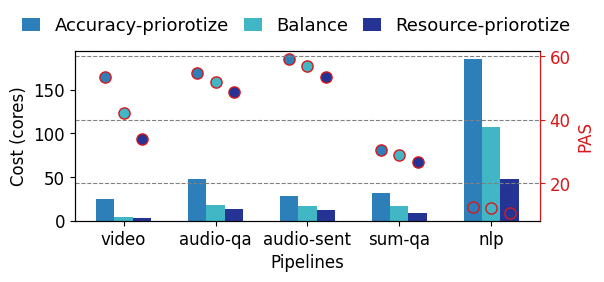

In [30]:
import importlib

importlib.reload(experiments.utils.drawing)

# data = {"Cost (cores)": total_core_changes_total, "Accuracy": accuracy_changes_total}
data = {"Cost (cores)": total_core_changes_total, "PAS": accuracy_changes_total}

experiments.utils.drawing.draw_objective_preference(
    data,
    series_meta=series_meta,
    xlabel=xlabel,
    filename=f"{FIGURES_PATH}/objective-preferences-mult",
    colors=["#2c7fb8", "#41b6c4", "#253494"],
    bar_width=0.2,
    bbox_to_anchor=(1.1, 1.3),
)